In [ ]:
#This file is modified from the https://github.com/gaoliyao/sindy-shred/blob/main/sst_sindy_shred.ipynb

In [1]:
import sys
print(sys.executable)
sys.path.insert(0, './SINDy_SHRED') #import SINDy_SHRED

import numpy as np
from processdata import TimeSeriesDataset

import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import sindy
import os

import xarray as xr

import cartopy.crs as ccrs  #for plot the coastline 
import cartopy.feature as cfeature 

import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

os.environ["CUDA_VISIBLE_DEVICES"]="0"

num_sensors = 250
lags = 52

#We load the data and assign it to the X matrix

# load data
ds = xr.open_dataset('./project_Data/t2m.nc') # change to 't2m.nc' for temperature data
t2m = ds['t2m'] # 'msl' is the variable name for slp, change to 't2m' for temperature data

# get longitude values
dlongitude = ds['longitude']
lon = dlongitude.values

# get latitude values 
dlatitude = ds['latitude']
lat = dlatitude.values

# mesh for (lo,lat)
lon2d, lat2d = np.meshgrid(lon, lat)

# dimensions of data
n_samples = t2m.values.shape[0]
n_lat = 101 
n_lon = 161
shape = (n_samples, n_lat, n_lon)

# define reshape (n_lat,n_lon) <-- (n_lat*n_lon,1)
def reshape_mode(mode_vec):
    return mode_vec.reshape(n_lat, n_lon)

# transform it into (n_lat * n_lon, n_samples) from ds (n_samples, n_lat, n_lon)
load_X = t2m.values.reshape(t2m.shape[0], -1)
n = load_X.shape[0]
m = load_X.shape[1]
print(load_X.shape)

# fixed sensor position
# grid_dim = int(np.sqrt(num_sensors))
# lat_indices = np.linspace(0, n_lat - 1, grid_dim, dtype=int)
# lon_indices = np.linspace(0, n_lon - 1, grid_dim, dtype=int)
# sensor_coords = [(lat, lon) for lat in lat_indices for lon in lon_indices]
# sensor_locations = np.array([lat * n_lon + lon for lat, lon in sensor_coords])
# num_sensors =  grid_dim * grid_dim

# random sensor position
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)


/home/lc/Desktop/ME5311/myvenvME5311/bin/python
(16071, 16261)


(2296, 16261)


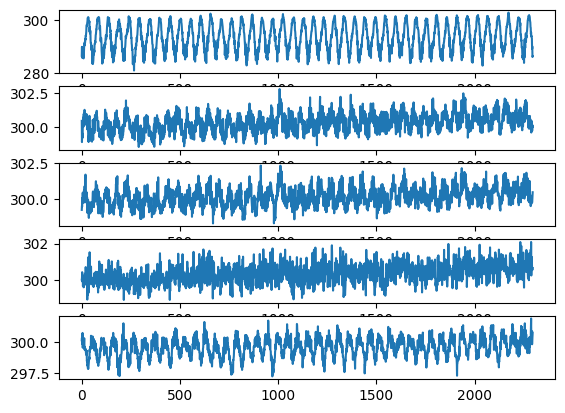

In [2]:

#filter
from scipy.signal import butter, filtfilt

def lowpass_filter(data, cutoff=0.1, fs=1.0, order=5):
   b, a = butter(order, cutoff / (0.5 * fs), btype='low')
   return filtfilt(b, a, data, axis=0)
    
load_X  = lowpass_filter(load_X[:, :])

#sample every 7 times
transformed_X1  = load_X[::7,:]
n_samples = transformed_X1.shape[0]
n = n_samples
print(transformed_X1.shape)

sub_index_X = transformed_X1[:,sensor_locations]
fig, ax = plt.subplots(5)
for i in range(5):
    ax[i].plot(sub_index_X[:,i])


In [3]:
#train/validation/test 
Ndata = n_samples - lags
indices = np.arange(Ndata)

train_size = int(Ndata * 0.8)   # 80%
valid_size = int(Ndata * 0.1)   # 10%
test_size  = Ndata - train_size - valid_size  # 10%

train_indices = indices[:train_size]                   
valid_indices = indices[train_size : train_size + valid_size]  
test_indices  = indices[train_size + valid_size :]     

print(len(train_indices))
print(len(valid_indices))
print(len(test_indices))

sc = MinMaxScaler()
sc = sc.fit(transformed_X1[train_indices])
transformed_X = sc.transform(transformed_X1)

1795
224
225


In [4]:
### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

print(train_data_in.shape)

torch.Size([1795, 52, 250])


In [5]:
#SINDy library
latent_dim = 3
poly_order = 3
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)

In [6]:
#training
import sindy_shred
shred = sindy_shred.SINDy_SHRED(num_sensors, m, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1, 
                                 library_dim=library_dim, poly_order=poly_order, include_sine=include_sine, dt=1.0/lags*0.1, layer_norm=False).to(device)

validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=1000, lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=10.0, optimizer="AdamW", thres_epoch=100)

1 : tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(0.0253, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(0.0244, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(0.0241, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(0.0287, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(0.0287, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(0.0291, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(0.0330, device='cuda:0', grad_fn=<AddBackward0>)
11 : tensor(0.0312, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(0.0265, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(0.0310, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(0.0287, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(0.0371, device='cuda:0', grad_fn=<AddBackward0>)
16 : tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)
17 : tensor(0.0433, device='cuda:

398 : tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)
399 : tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)
400 : tensor(0.0101, device='cuda:0', grad_fn=<AddBackward0>)
Training epoch 400
Error tensor(0.2479, device='cuda:0')
401 : tensor(0.0107, device='cuda:0', grad_fn=<AddBackward0>)
402 : tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)
403 : tensor(0.0110, device='cuda:0', grad_fn=<AddBackward0>)
404 : tensor(0.0107, device='cuda:0', grad_fn=<AddBackward0>)
405 : tensor(0.0106, device='cuda:0', grad_fn=<AddBackward0>)
406 : tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)
407 : tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)
408 : tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)
409 : tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>)
410 : tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>)
411 : tensor(0.0106, device='cuda:0', grad_fn=<AddBackward0>)
412 : tensor(0.0106, device='cuda:0', grad_fn=<AddBackward0>)
413 : tensor(

529 : tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)
530 : tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)
531 : tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)
532 : tensor(0.0099, device='cuda:0', grad_fn=<AddBackward0>)
533 : tensor(0.0099, device='cuda:0', grad_fn=<AddBackward0>)
534 : tensor(0.0098, device='cuda:0', grad_fn=<AddBackward0>)
535 : tensor(0.0107, device='cuda:0', grad_fn=<AddBackward0>)
536 : tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)
537 : tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)
538 : tensor(0.0099, device='cuda:0', grad_fn=<AddBackward0>)
539 : tensor(0.0098, device='cuda:0', grad_fn=<AddBackward0>)
540 : tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)
541 : tensor(0.0103, device='cuda:0', grad_fn=<AddBackward0>)
542 : tensor(0.0101, device='cuda:0', grad_fn=<AddBackward0>)
543 : tensor(0.0102, device='cuda:0', grad_fn=<AddBackward0>)
544 : tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)
545 : te

In [7]:
# Rate of sparsity
torch.mean(shred.e_sindy.coefficient_mask*1.0)

tensor(0.5350, device='cuda:0')

In [8]:
#We then generate reconstructions from the test set and print mean square error compared to the ground truth.
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.005157298


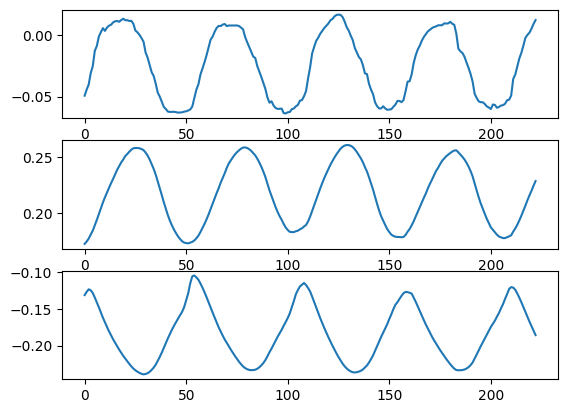

In [9]:
import pysindy as ps
from pysindy.differentiation import FiniteDifference
gru_outs, sindy_outs = shred.gru_outputs(test_dataset.X, sindy=True)
differentiation_method = FiniteDifference()

fig, ax = plt.subplots(latent_dim)
for i in range(latent_dim):
    ax[i].plot(gru_outs[1:,0,i].detach().cpu().numpy())

(x0)' = 0.800 1 + 2.663 x0 + 5.469 x2
(x1)' = 0.983 1 + 6.224 x0 + 2.939 x1 + 6.806 x2
(x2)' = -0.791 1 + -6.671 x0 + -3.816 x1 + -5.534 x2


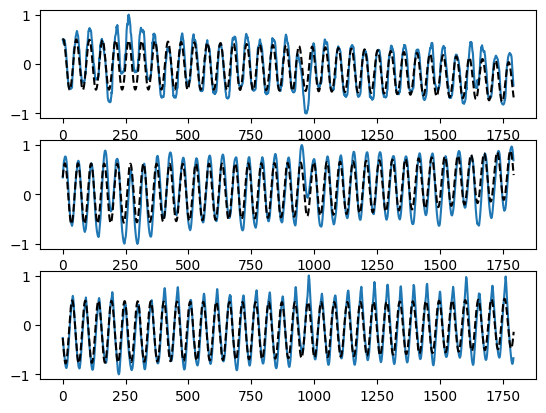

In [10]:
gru_outs, sindy_outs = shred.gru_outputs(train_dataset.X, sindy=True)
gru_outs = gru_outs[:,0,:]

###############Normalization###############
for i in range(latent_dim):
    gru_outs[:,i] = (gru_outs[:,i] - torch.min(gru_outs[:,i])) / (torch.max(gru_outs[:,i])-torch.min(gru_outs[:,i]))

gru_outs = 2 * gru_outs - 1

###############SINDy discovery###############

x = gru_outs.detach().cpu().numpy()

differentiation_method = ps.differentiation.FiniteDifference()
# differentiation_method = ps.differentiation.SmoothedFiniteDifference()

poly_order = 1

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.25, alpha=0.05),
    differentiation_method=differentiation_method,
    feature_library=ps.PolynomialLibrary(degree=poly_order)
)


model.fit(x, t=1.0/lags, ensemble=False)
model.print()


###############Plot the discovered SINDy model###############

t_train = np.arange(0, train_data_in.shape[0]/lags, 1/lags)
init_cond = np.zeros(latent_dim)
init_cond[:latent_dim] = gru_outs[0,:].detach().cpu().numpy()
x_sim = model.simulate(init_cond, t_train)

fig, ax = plt.subplots(latent_dim)
for i in range(latent_dim):
    ax[i].plot(gru_outs[:,i].detach().cpu().numpy())
    ax[i].plot(x_sim[:,i], "k--", label="model")

In [11]:
#Reload data from the entire training set
gru_outs_train, _ = shred.gru_outputs(train_dataset.X, sindy=True)
gru_outs_train = gru_outs_train[:,0,:]
gru_outs_val, _ = shred.gru_outputs(valid_dataset.X, sindy=True)
gru_outs_val = gru_outs_val[:,0,:]
gru_outs_test, _ = shred.gru_outputs(test_dataset.X, sindy=True)
gru_outs_test = gru_outs_test[:,0,:]

gru_outs_all = np.zeros((Ndata-1, latent_dim))
gru_outs_all[:train_size-1,:] = gru_outs_train.detach().cpu().numpy()
gru_outs_all[train_size : train_size + valid_size-1,:] = gru_outs_val.detach().cpu().numpy()
gru_outs_all[(train_size + valid_size):,:] = gru_outs_test.detach().cpu().numpy()
gru_outs_numpy = gru_outs_train.detach().cpu().numpy()
for i in range(latent_dim):
    gru_outs_all[:,i] = (gru_outs_all[:,i] - np.min(gru_outs_numpy[:,i])) / (np.max(gru_outs_numpy[:,i])-np.min(gru_outs_numpy[:,i]))

gru_outs_all = 2 * gru_outs_all - 1

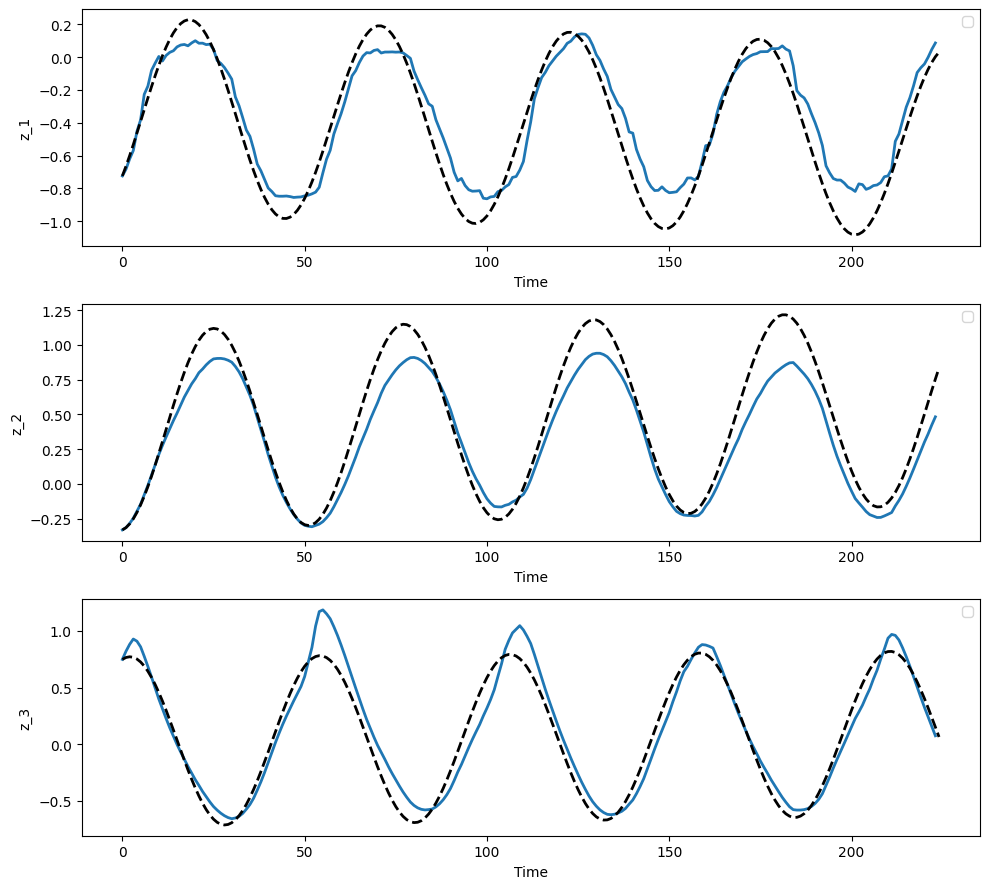

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.io import loadmat

###############Normalization###############
gru_outs_test_np = gru_outs_test.detach().cpu().numpy()

for i in range(latent_dim):
    gru_outs_test_np[:, i] = (gru_outs_test_np[:, i] - np.min(gru_outs_numpy[:, i])) / (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i]))

gru_outs_test_np = 2 * gru_outs_test_np - 1  # Transform to [-1, 1]

################Forward simulation with the model################
t_test = np.arange(0, test_data_in.shape[0]*1/lags, 1/lags)
init_cond = np.zeros(latent_dim)
init_cond[:latent_dim] = gru_outs_test_np[0, :]
x_sim_test = model.simulate(init_cond, t_test)

# Plotting for each latent dimension: True vs SINDy
fig, ax = plt.subplots(latent_dim, figsize=(10, latent_dim * 3))

for i in range(latent_dim):
#    ax[i].plot(gru_outs_test_np[:, i], label='GRU Signal', linewidth=2)
#    ax[i].plot(x_sim_test[:, i], "k--", label='SINDy Approximation', linewidth=2)
    ax[i].plot(gru_outs_test_np[:, i], linewidth=2)
    ax[i].plot(x_sim_test[:, i], "k--",  linewidth=2)
    
    ax[i].legend()
    ax[i].set_ylabel(f'z_{i+1}')
    ax[i].set_xlabel('Time')

plt.tight_layout()
plt.show()


In [13]:
###############Predict back in the pixel space###############

# Step 1: Reverse Min-Max scaling for SINDy-simulated data (x_sim_test)
x_sim_test = np.array(x_sim_test)  # Ensure it's a numpy array if needed

# Revert the scaling from [-1, 1] back to [0, 1]
x_sim_test = (x_sim_test + 1) / 2  

# Perform the Min-Max reverse transformation using the original min/max values
for i in range(latent_dim):  
    x_sim_test[:, i] = x_sim_test[:, i] * (np.max(gru_outs_numpy[:, i]) - np.min(gru_outs_numpy[:, i])) + np.min(gru_outs_numpy[:, i])

# Perform the decoder reconstruction using the transformed SINDy-simulated data
latent_pred_sindy = torch.FloatTensor(x_sim_test).cuda()  # Convert to torch tensor for reconstruction

# Pass the SINDy-simulated latent space data through the decoder
output_sindy = shred.linear1(latent_pred_sindy)
output_sindy = shred.dropout(output_sindy)
output_sindy = torch.nn.functional.relu(output_sindy)
output_sindy = shred.linear2(output_sindy)
output_sindy = shred.dropout(output_sindy)
output_sindy = torch.nn.functional.relu(output_sindy)
output_sindy = shred.linear3(output_sindy)

# Detach and convert the reconstructed data back to numpy for visualization
output_sindy_np = sc.inverse_transform(output_sindy.detach().cpu().numpy())
        
# Initialize an empty array with the same shape as the original data
reconstructed_data_sindy = np.zeros_like(n_lat*n_lon)


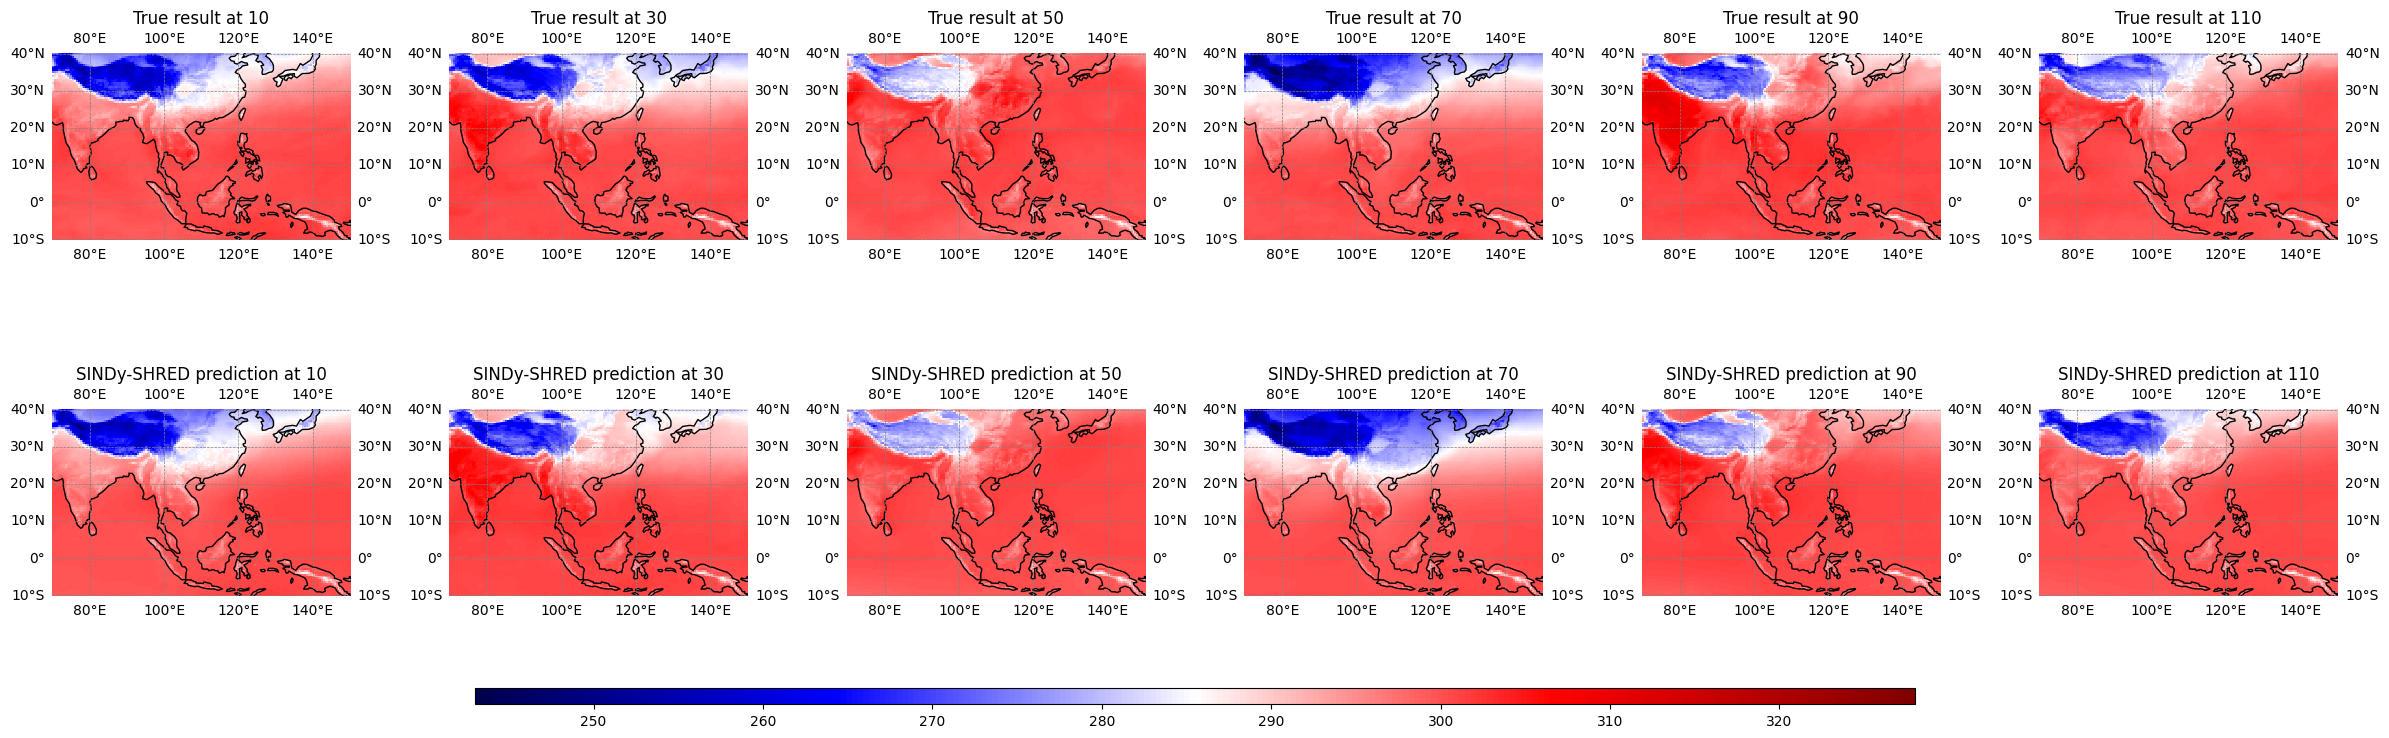

In [14]:
# Assuming decoder_model is your decoder（shred）, and timesteps are [50,100,150,200] or any set of timesteps you'd like to plot
timesteps = [10,30,50,70,90,110]  # Define timesteps to plot in testsets
fig, axes = plt.subplots(2, len(timesteps), 
                         figsize=(4 * len(timesteps), 8),
                         subplot_kw={'projection': ccrs.PlateCarree()})


for row in range(2):  
    for col in range(len(timesteps)):

        t = timesteps[col]

        # Copy the SINDy-reconstructed values back to the locations for the current timestep
        reconstructed_data_sindy = output_sindy_np[t, :]  # Use the selected timestep
        #print(np.sum(np.square(output_sindy_np[t,:]-output_sindy_np[t+1, :])))

        if row == 0 :
            field = test_ground_truth[t,:] 
        elif row == 1 :
            field = reconstructed_data_sindy
        #reshape
        field = field.reshape(n_lat, n_lon)  # reshape
        
        #plot fields for ture\prediction results
        ax = axes[row, col]
        im = ax.pcolormesh(lon2d, lat2d, field, shading='auto',
                    transform=ccrs.PlateCarree(), cmap='seismic',vmin=-30+273,vmax=55+273)
        
        # coastline
        ax.coastlines(resolution='110m')
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
        ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
            
        ax.axis('off')

        if row == 0:
            ax.set_title(f"True result at {t}")
        elif row == 1 :
            ax.set_title(f"SINDy-SHRED prediction at {t}")           

        ax.axis('off')
  
           
# Add a single shared colorbar
# Reserve more space at the bottom
plt.tight_layout(rect=[0, 0.03, 1, 1])  # top-left:0, bottom:0.05
    
# Add colorbar below figure, outside subplots
cbar_ax = fig.add_axes([0.2, 0.04, 0.6, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    
plt.show()

In [15]:
#save model
torch.save(shred.state_dict(), 'SINDy_SHRED_results/shred_model_t2m.pt')

import joblib
joblib.dump(model, 'SINDy_SHRED_results/sindy_model_t2m.pkl')

joblib.dump(sc, 'SINDy_SHRED_results/minmax_scaler_t2m.pkl')

#save results
np.save('SINDy_SHRED_results/x_sim_test_t2m.npy', x_sim_test)
np.save('SINDy_SHRED_results/output_sindy_t2m.npy', output_sindy_np)
np.save('SINDy_SHRED_results/ground_truth_t2m.npy', test_ground_truth)

print("finishing saveing models and results")

finishing saveing models and results
